In [1]:
# Importing the required libraries
from IPython.display import display
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import time
import easydict
import copy

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, LinearLR

from time_transformer.transformer import Transformer
from time_transformer.utils_valid_loss_point import compute_val_point_score

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

# Defining DOE custom mape formula
def new_mape(y_true, y_pred, max_val):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max_val)) * 100

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


#### FETCHING AND PROCESSING CALENDER FEATURES

In [2]:
# Specifying the path of file
path= r"C:\Users\sashah8\DOE_Graph_Attention_Transformer\DOE MODEL TRAINING\Cleaned data - Station mapped"
dataset = "L1"

# Listing just the required files
fileList = os.listdir(os.path.join(path, dataset))

# Previewing the required file names
print(fileList)

['MIDATL.csv', 'SOUTH.csv', 'WEST.csv']


In [3]:
# Just for previewing the column name
display(pd.read_csv(os.path.join(path, dataset, fileList[1])).head(2))

,utc,ept,mw,tmpf
0,2015-01-01 05:00:00,2015-01-01 00:00:00,12571.309,32.0
1,2015-01-01 06:00:00,2015-01-01 01:00:00,12449.182,32.0


In [4]:
# Just for previewing the column name
data = pd.read_csv(os.path.join(path, dataset, fileList[0]), parse_dates=['ept'], usecols=['ept', 'mw', 'tmpf'])
print("Sample dataframe: ")
display(data.head(2))

Sample dataframe: 


,ept,mw,tmpf
0,2015-01-01 00:00:00,31660.636,28.94
1,2015-01-01 01:00:00,30766.066,28.94


In [5]:
# Fetching the date column only
date_col = data.ept.copy()
date_col.name = "AA_ept"
date_col.head(2)

0   2015-01-01 00:00:00
1   2015-01-01 01:00:00
Name: AA_ept, dtype: datetime64[ns]

In [6]:
# Creating the calendar features
date = pd.DataFrame()
date['Month'] = date_col.dt.month
date['Day'] = date_col.dt.day
date['Hour'] = date_col.dt.hour
date['Weekday'] = date_col.dt.weekday

print("Sample calendar features: ")
display(date.head(2))

print("Available unique categories: ")
display(date.nunique())

print("Total number of observations: ", len(date))

Sample calendar features: 


,Month,Day,Hour,Weekday
0,1,1,0,3
1,1,1,1,3


Available unique categories: 


Month      12
Day        31
Hour       24
Weekday     7
dtype: int64

Total number of observations:  43824


In [7]:
# One-hot encoding the categorical calendar features
date_enc = OneHotEncoder(sparse_output=False)
categorical_data = date_enc.fit_transform(date)
display(categorical_data)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
category_count = [len(x_len) for x_len in date_enc.categories_]
category_count

[12, 31, 24, 7]

#### PROCESSING CONTINUOUS FEATURES FOR ALL AVAILABLE ZONES

PROCESSING LOAD DATA

In [9]:
# Fetching and concatenating the data
load_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["mw"]) for fileName in fileList], axis= 1)
load_ds.columns = [i.removesuffix('.csv') for i in fileList]
load_ds = load_ds.add_suffix("_A_LOAD")
display(load_ds.tail(2))

,MIDATL_A_LOAD,SOUTH_A_LOAD,WEST_A_LOAD
43822,28458.691,10838.550,45132.982
43823,27428.213,10592.674,43501.529


In [10]:
lag_24_ahead = True

# Creating 1-day lag loads
if lag_24_ahead:
    lag_val = 1
else:
    lag_val = 2

load_lag_1 = load_ds.shift(24*lag_val).add_suffix("_LAG1")
display(load_lag_1.tail(2))

,MIDATL_A_LOAD_LAG1,SOUTH_A_LOAD_LAG1,WEST_A_LOAD_LAG1
43822,29356.335,9765.158,45404.894
43823,27736.439,9225.152,43190.705


In [11]:
# Creating 7-day lag loads
load_lag_7 = load_ds.shift(24*7).add_suffix("_LAG7")
display(load_lag_7.tail(2))

,MIDATL_A_LOAD_LAG7,SOUTH_A_LOAD_LAG7,WEST_A_LOAD_LAG7
43822,29955.427,11519.032,41556.164
43823,28929.156,11314.571,40399.011


In [12]:
# Drop index for equalizing data
drop_idx = load_lag_7.dropna(axis=0).index[0]
print("Drop data before: ", drop_idx)

Drop data before:  168


ADDING LAST LOAD VALUE FROM PREVIOUS DAY AS FEATURE

In [13]:
n = 24
last_elem = pd.DataFrame(np.column_stack([np.concatenate([np.repeat(load_ds[col].values[n-1::n], n), 
                                                          np.repeat(np.NaN, len(load_ds)%n)]) for col in load_ds.columns]))
last_elem.columns = [i.removesuffix('.csv') for i in fileList]
last_elem = last_elem.add_suffix("_LAST_ELEM")
last_elem = last_elem.shift(24)
last_elem

,MIDATL_LAST_ELEM,SOUTH_LAST_ELEM,WEST_LAST_ELEM
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
43819,27736.439,9225.152,43190.705
43820,27736.439,9225.152,43190.705
43821,27736.439,9225.152,43190.705
43822,27736.439,9225.152,43190.705


FINDING MIN AND MAX VALUES OF LOAD ON PREVIOUS DAY

In [14]:
# Creating block of indices repeating after every 24 rows
blocks = [load_lag_1[i:i+24] for i in range(0, len(load_lag_1), 24)]

# Finding max and min values on the previous day (T-1)
max_values_df = pd.DataFrame([block.max() for block in blocks])
max_values_df = max_values_df.iloc[np.repeat(np.arange(len(max_values_df)), 24)]
max_values_df = max_values_df.reset_index(drop=True)

max_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in max_values_df.columns]
max_values_df = max_values_df.add_suffix("_PREV_MAX")
print("Columns with max load from previous day: ")
display(max_values_df.tail(2))
print("\n")

min_values_df = pd.DataFrame([block.min() for block in blocks])
min_values_df = min_values_df.iloc[np.repeat(np.arange(len(min_values_df)), 24)]
min_values_df = min_values_df.reset_index(drop=True)

min_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in min_values_df.columns]
min_values_df = min_values_df.add_suffix("_PREV_MIN")
print("Columns with min load from previous day: ")
display(min_values_df.tail(2))
print("\n")

Columns with max load from previous day: 


,MIDATL_PREV_MAX,SOUTH_PREV_MAX,WEST_PREV_MAX
43822,33886.695,11062.641,49664.699
43823,33886.695,11062.641,49664.699




Columns with min load from previous day: 


,MIDATL_PREV_MIN,SOUTH_PREV_MIN,WEST_PREV_MIN
43822,23677.338,8222.136,34568.761
43823,23677.338,8222.136,34568.761


In [15]:
pd.DataFrame(load_lag_1.iloc[-24:].max()).T

,MIDATL_A_LOAD_LAG1,SOUTH_A_LOAD_LAG1,WEST_A_LOAD_LAG1
0,33886.695,11062.641,49664.699


PROCESSING TEMPERATURE DATA

In [16]:
# Fetching and concatenating the data
temp_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["tmpf"]) for fileName in fileList], axis= 1)
temp_ds.columns = [i.removesuffix('.csv') for i in fileList]
temp_ds = temp_ds.add_suffix("_A_TEMP")
display(temp_ds.tail(2))

,MIDATL_A_TEMP,SOUTH_A_TEMP,WEST_A_TEMP
43822,45.0,46.0,34.0
43823,43.0,45.0,33.1


### PREPARING X AND Y PART

In [17]:
# Concatenating the engineered features
X_continuous = pd.concat([date_col, load_lag_1, load_lag_7, temp_ds, last_elem, max_values_df, min_values_df], axis=1)
X_continuous = X_continuous.sort_index(axis=1)
X_continuous = X_continuous.iloc[drop_idx:].reset_index(drop=True)

# Fetching the train index from the processed dataframe
train_end_idx = X_continuous[X_continuous.AA_ept.dt.year.between(2015, 2018)].index[-1]
print("NUMBER OF COLUMNS: ", len(X_continuous.columns), "\n")
print("The train-test split index is: ", train_end_idx)
print("The last date of train dataset: ")
display(X_continuous.loc[:train_end_idx].tail(2))

print("The first date of test dataset: ")
display(X_continuous.loc[train_end_idx + 1:].head(2))
print('\n')

# Dropping the datetime column after fetching the train-test split index
X_continuous = X_continuous.drop(columns=['AA_ept'])
print("LENGTH OF DATASET: ", len(X_continuous))
display(X_continuous.tail(2))
print("\n")

# First few values of the continuous values dataframe
print("First few values of continuous values dataframe: ")
display(X_continuous.head(2))

NUMBER OF COLUMNS:  19 

The train-test split index is:  34895
The last date of train dataset: 


,AA_ept,MIDATL_A_LOAD_LAG1,MIDATL_A_LOAD_LAG7,MIDATL_A_TEMP,MIDATL_LAST_ELEM,MIDATL_PREV_MAX,MIDATL_PREV_MIN,SOUTH_A_LOAD_LAG1,SOUTH_A_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,WEST_A_LOAD_LAG1,WEST_A_LOAD_LAG7,WEST_A_TEMP,WEST_LAST_ELEM,WEST_PREV_MAX,WEST_PREV_MIN
34894,2018-12-31 22:00:00,30523.308,30164.732,46.0,28960.725,33002.665,25172.324,11098.212,11870.76,57.9,10679.493,11830.385,9655.646,45579.096,45389.004,60.1,43485.199,48245.288,40687.59
34895,2018-12-31 23:00:00,28960.725,28912.872,46.9,28960.725,33002.665,25172.324,10679.493,11628.11,61.0,10679.493,11830.385,9655.646,43485.199,44236.049,59.0,43485.199,48245.288,40687.59


The first date of test dataset: 


,AA_ept,MIDATL_A_LOAD_LAG1,MIDATL_A_LOAD_LAG7,MIDATL_A_TEMP,MIDATL_LAST_ELEM,MIDATL_PREV_MAX,MIDATL_PREV_MIN,SOUTH_A_LOAD_LAG1,SOUTH_A_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,WEST_A_LOAD_LAG1,WEST_A_LOAD_LAG7,WEST_A_TEMP,WEST_LAST_ELEM,WEST_PREV_MAX,WEST_PREV_MIN
34896,2019-01-01 00:00:00,27705.901,27638.251,48.9,26808.48,35036.92,26734.653,10440.547,11370.606,64.0,9565.197,12291.394,9565.197,42003.07,42529.114,57.9,38951.401,47708.74,38951.401
34897,2019-01-01 01:00:00,27031.480,26801.717,52.0,26808.48,35036.92,26734.653,10240.250,11300.246,66.0,9565.197,12291.394,9565.197,40758.01,41413.051,54.0,38951.401,47708.74,38951.401




LENGTH OF DATASET:  43656


,MIDATL_A_LOAD_LAG1,MIDATL_A_LOAD_LAG7,MIDATL_A_TEMP,MIDATL_LAST_ELEM,MIDATL_PREV_MAX,MIDATL_PREV_MIN,SOUTH_A_LOAD_LAG1,SOUTH_A_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,WEST_A_LOAD_LAG1,WEST_A_LOAD_LAG7,WEST_A_TEMP,WEST_LAST_ELEM,WEST_PREV_MAX,WEST_PREV_MIN
43654,29356.335,29955.427,45.0,27736.439,33886.695,23677.338,9765.158,11519.032,46.0,9225.152,11062.641,8222.136,45404.894,41556.164,34.0,43190.705,49664.699,34568.761
43655,27736.439,28929.156,43.0,27736.439,33886.695,23677.338,9225.152,11314.571,45.0,9225.152,11062.641,8222.136,43190.705,40399.011,33.1,43190.705,49664.699,34568.761




First few values of continuous values dataframe: 


,MIDATL_A_LOAD_LAG1,MIDATL_A_LOAD_LAG7,MIDATL_A_TEMP,MIDATL_LAST_ELEM,MIDATL_PREV_MAX,MIDATL_PREV_MIN,SOUTH_A_LOAD_LAG1,SOUTH_A_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,WEST_A_LOAD_LAG1,WEST_A_LOAD_LAG7,WEST_A_TEMP,WEST_LAST_ELEM,WEST_PREV_MAX,WEST_PREV_MIN
0,34280.487,31660.636,12.92,40278.503,46771.182,33197.699,12369.371,12571.309,17.06,16866.808,17994.681,12223.193,54921.369,49769.768,1.94,64477.44,71090.7,53383.381
1,33507.163,30766.066,12.02,40278.503,46771.182,33197.699,12298.817,12449.182,15.98,16866.808,17994.681,12223.193,53773.069,48714.914,1.04,64477.44,71090.7,53383.381


In [18]:
X_continuous.isna().any()

MIDATL_A_LOAD_LAG1    False
MIDATL_A_LOAD_LAG7    False
MIDATL_A_TEMP         False
MIDATL_LAST_ELEM      False
MIDATL_PREV_MAX       False
MIDATL_PREV_MIN       False
SOUTH_A_LOAD_LAG1     False
SOUTH_A_LOAD_LAG7     False
SOUTH_A_TEMP          False
SOUTH_LAST_ELEM       False
SOUTH_PREV_MAX        False
SOUTH_PREV_MIN        False
WEST_A_LOAD_LAG1      False
WEST_A_LOAD_LAG7      False
WEST_A_TEMP           False
WEST_LAST_ELEM        False
WEST_PREV_MAX         False
WEST_PREV_MIN         False
dtype: bool

In [19]:
X_categorical = pd.DataFrame(categorical_data)
X_categorical = X_categorical.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(X_categorical))
print("NUMBER OF COLUMNS: ", len(X_categorical.columns))
display(X_categorical.tail(2))

LENGTH OF DATASET:  43656
NUMBER OF COLUMNS:  74


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
43654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
Y = load_ds.copy()
Y = Y.sort_index(axis=1)
Y = Y.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(Y))
display(Y.tail(2))

LENGTH OF DATASET:  43656


,MIDATL_A_LOAD,SOUTH_A_LOAD,WEST_A_LOAD
43654,28458.691,10838.550,45132.982
43655,27428.213,10592.674,43501.529


In [21]:
### SPLITTING THE DATA INTO TRAINING AND TESTING
print("Train samples: ", len(X_continuous.loc[:train_end_idx]))
print("Test samples: ", len(X_continuous.loc[train_end_idx + 1:]))

Train samples:  34896
Test samples:  8760


In [22]:
# Splitting the continuous data into training and test split
X_continuous_train,  X_continuous_test = X_continuous.loc[:train_end_idx], X_continuous.loc[train_end_idx+1:]
print("Train split of continuous data: ")
display(X_continuous_train.tail(2))

# Splitting the categorical data into training and test split
X_categorical_train, X_categorical_test = X_categorical.loc[:train_end_idx], X_categorical.loc[train_end_idx+1:]
print("Train split of categorical data: ")
display(X_categorical_train.tail(2))

# Splitting the target into training and test split
Y_train, Y_test = Y.loc[:train_end_idx],  Y.loc[train_end_idx+1:]
print("Train split of target data Y: ")
display(Y_train.tail(2))

Train split of continuous data: 


,MIDATL_A_LOAD_LAG1,MIDATL_A_LOAD_LAG7,MIDATL_A_TEMP,MIDATL_LAST_ELEM,MIDATL_PREV_MAX,MIDATL_PREV_MIN,SOUTH_A_LOAD_LAG1,SOUTH_A_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,WEST_A_LOAD_LAG1,WEST_A_LOAD_LAG7,WEST_A_TEMP,WEST_LAST_ELEM,WEST_PREV_MAX,WEST_PREV_MIN
34894,30523.308,30164.732,46.0,28960.725,33002.665,25172.324,11098.212,11870.76,57.9,10679.493,11830.385,9655.646,45579.096,45389.004,60.1,43485.199,48245.288,40687.59
34895,28960.725,28912.872,46.9,28960.725,33002.665,25172.324,10679.493,11628.11,61.0,10679.493,11830.385,9655.646,43485.199,44236.049,59.0,43485.199,48245.288,40687.59


Train split of categorical data: 


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
34894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Train split of target data Y: 


,MIDATL_A_LOAD,SOUTH_A_LOAD,WEST_A_LOAD
34894,28248.171,10005.343,40608.049
34895,26808.480,9565.197,38951.401


In [23]:
print("Shape for continuous variable: ")
print(X_continuous_train.shape, X_continuous_test.shape, "\n")
print("Shape for categorical variable: ")
print(X_categorical_train.shape, X_categorical_test.shape, "\n")
print("Shape for target variable: ")
print(Y_train.shape, Y_test.shape, "\n")
print("Does it cover entire training set: ", (X_continuous_train.shape[0] +
                                              X_continuous_test.shape[0]) == len(X_continuous))

Shape for continuous variable: 
(34896, 18) (8760, 18) 

Shape for categorical variable: 
(34896, 74) (8760, 74) 

Shape for target variable: 
(34896, 3) (8760, 3) 

Does it cover entire training set:  True


### SCALING THE DATA

In [24]:
# Scaling values using min-max scaler
mm_scaler_X = MinMaxScaler()
mm_scaler_Y = MinMaxScaler()

In [25]:
# Scaling continuous X train part
X_scaled_continuous_train = mm_scaler_X.fit_transform(X_continuous_train)

# Using the fit_scaler to scale the X test part
X_scaled_continuous_test = mm_scaler_X.transform(X_continuous_test)

print("Scaled continuous X train: ")
print("Shape: ", X_scaled_continuous_train.shape)
display(X_scaled_continuous_train)

Scaled continuous X train: 
Shape:  (34896, 18)


array([[0.40103697, 0.33111147, 0.1155303 , ..., 0.93525362, 0.81761405,
        0.75715536],
       [0.38039646, 0.30723482, 0.10606061, ..., 0.93525362, 0.81761405,
        0.75715536],
       [0.37213667, 0.29216876, 0.09469697, ..., 0.93525362, 0.81761405,
        0.75715536],
       ...,
       [0.33791593, 0.31494172, 0.45307239, ..., 0.30197771, 0.22529237,
        0.33110397],
       [0.30075546, 0.29118483, 0.46359428, ..., 0.30197771, 0.22529237,
        0.33110397],
       [0.25904911, 0.25777189, 0.47306397, ..., 0.30197771, 0.22529237,
        0.33110397]])

In [26]:
# Scaling target Y train part
Y_scaled_train = mm_scaler_Y.fit_transform(Y_train)

# Using the fit_scaler to scale the Y test part
Y_scaled_test = mm_scaler_Y.transform(Y_test)

print("Scaled continuous Y train: ")
print("Shape: ", Y_scaled_train.shape)
display(Y_scaled_train)

Scaled continuous Y train: 
Shape:  (34896, 3)


array([[0.52691799, 0.67783968, 0.67398833],
       [0.51204733, 0.68089624, 0.65555375],
       [0.50481553, 0.69084033, 0.65197573],
       ...,
       [0.27933032, 0.26364331, 0.2379926 ],
       [0.24003059, 0.22635782, 0.20689414],
       [0.20160432, 0.19711778, 0.17187289]])

In [27]:
# Converting a multivariate dataset into slices of samples
def split_data(calendar_data, x_data, y_data, n_steps, n_overlap):
    calendar, x, y = list(), list(), list()
    for i in range(0, len(x_data), n_steps-n_overlap):

        # Finding the split index
        end_idx = i + n_steps

        # Break the loop at end of dataset
        if end_idx > len(x_data):
            break

        # Appending the custom created samples with desired time-steps and features
        sample_calendar, sample_x, sample_y = calendar_data[i:end_idx, :], \
                                              x_data[i:end_idx, :], \
                                              y_data[i:end_idx, :]
        calendar.append(sample_calendar)
        x.append(sample_x)
        y.append(sample_y)

    return np.array(calendar), np.array(x), np.array(y)

In [28]:
num_steps = 24
train_num_overlap = 23
test_num_overlap = 0

processed_data_train = split_data(calendar_data=X_categorical_train.to_numpy(),
                            x_data=X_scaled_continuous_train,
                            y_data=Y_scaled_train,
                            n_steps=num_steps, n_overlap=train_num_overlap)

processed_data_test = split_data(calendar_data=X_categorical_test.to_numpy(),
                            x_data=X_scaled_continuous_test,
                            y_data=Y_scaled_test,
                            n_steps=num_steps, n_overlap=test_num_overlap)

print("Shape of the created samples for training: ", processed_data_train[1].shape)
print("Shape of the created samples for testing: ", processed_data_test[1].shape)

Shape of the created samples for training:  (34873, 24, 18)
Shape of the created samples for testing:  (365, 24, 18)


In [29]:
## Sample check for sanity
print("First sample: \n")
display(processed_data_train[1][0])

First sample: 



array([[0.40103697, 0.33111147, 0.1155303 , 0.87371891, 0.6785787 ,
        0.61915578, 0.38340632, 0.39682159, 0.18686275, 0.80077901,
        0.70497893, 0.54733625, 0.50947523, 0.40057128, 0.11438475,
        0.93525362, 0.81761405, 0.75715536],
       [0.38039646, 0.30723482, 0.10606061, 0.87371891, 0.6785787 ,
        0.61915578, 0.37871924, 0.38870837, 0.17627451, 0.80077901,
        0.70497893, 0.54733625, 0.48520037, 0.37827185, 0.10571924,
        0.93525362, 0.81761405, 0.75715536],
       [0.37213667, 0.29216876, 0.09469697, 0.87371891, 0.6785787 ,
        0.61915578, 0.37369534, 0.37849729, 0.17627451, 0.80077901,
        0.70497893, 0.54733625, 0.47696243, 0.36062885, 0.08665511,
        0.93525362, 0.81761405, 0.75715536],
       [0.37531494, 0.28415649, 0.09469697, 0.87371891, 0.6785787 ,
        0.61915578, 0.3828083 , 0.38240631, 0.16745098, 0.80077901,
        0.70497893, 0.54733625, 0.48007652, 0.35005501, 0.0762565 ,
        0.93525362, 0.81761405, 0.75715536],
    

In [30]:
print("Second sample: \n")
display(processed_data_train[1][1])

Second sample: 



array([[0.38039646, 0.30723482, 0.10606061, 0.87371891, 0.6785787 ,
        0.61915578, 0.37871924, 0.38870837, 0.17627451, 0.80077901,
        0.70497893, 0.54733625, 0.48520037, 0.37827185, 0.10571924,
        0.93525362, 0.81761405, 0.75715536],
       [0.37213667, 0.29216876, 0.09469697, 0.87371891, 0.6785787 ,
        0.61915578, 0.37369534, 0.37849729, 0.17627451, 0.80077901,
        0.70497893, 0.54733625, 0.47696243, 0.36062885, 0.08665511,
        0.93525362, 0.81761405, 0.75715536],
       [0.37531494, 0.28415649, 0.09469697, 0.87371891, 0.6785787 ,
        0.61915578, 0.3828083 , 0.38240631, 0.16745098, 0.80077901,
        0.70497893, 0.54733625, 0.48007652, 0.35005501, 0.0762565 ,
        0.93525362, 0.81761405, 0.75715536],
       [0.3957987 , 0.28904144, 0.09469697, 0.87371891, 0.6785787 ,
        0.61915578, 0.41536086, 0.39491477, 0.14627451, 0.80077901,
        0.70497893, 0.54733625, 0.49845237, 0.34712539, 0.06759099,
        0.93525362, 0.81761405, 0.75715536],
    

In [31]:
# Dividing the sampled data - training
categorical_samples_training = torch.Tensor(processed_data_train[0])
continuous_samples_training = torch.Tensor(processed_data_train[1])
target_samples_training = torch.Tensor(processed_data_train[2])

# Dividing the sampled data - testing
categorical_samples_testing = torch.Tensor(processed_data_test[0])
continuous_samples_testing = torch.Tensor(processed_data_test[1])
target_samples_testing = torch.Tensor(processed_data_test[2])

In [32]:
print("Shape of categorical samples - training: ", categorical_samples_training.shape)
print("Shape of continuous samples - training: ", continuous_samples_training.shape)
print("Shape of target samples - training: ", target_samples_training.shape)
print("\n")
print("Shape of categorical samples - testing: ", categorical_samples_testing.shape)
print("Shape of continuous samples - testing: ", continuous_samples_testing.shape)
print("Shape of target samples - testing: ", target_samples_testing.shape)

Shape of categorical samples - training:  torch.Size([34873, 24, 74])
Shape of continuous samples - training:  torch.Size([34873, 24, 18])
Shape of target samples - training:  torch.Size([34873, 24, 3])


Shape of categorical samples - testing:  torch.Size([365, 24, 74])
Shape of continuous samples - testing:  torch.Size([365, 24, 18])
Shape of target samples - testing:  torch.Size([365, 24, 3])


### CREATING DATALOADER

In [33]:
BATCH_SIZE = 1024

In [34]:
class TimeSeriesLoader(Dataset):
    def __init__(self, categorical, continuous, target):
        self.categorical, self.continuous, self.target = categorical, continuous, target

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        return self.categorical[idx], self.continuous[idx], self.target[idx]

In [35]:
train_dataset = TimeSeriesLoader(categorical_samples_training,
                                 continuous_samples_training,
                                 target_samples_training)

test_dataset = TimeSeriesLoader(categorical_samples_testing,
                                continuous_samples_testing,
                                target_samples_testing)

In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [37]:
print("Number of batches in train dataloader: ", len(train_dataloader))
print("Number of batches in test dataloader: ", len(test_dataloader))

Number of batches in train dataloader:  35
Number of batches in test dataloader:  1


In [38]:
categorical_var_shape = train_dataloader.dataset.categorical.shape
continuous_var_shape = train_dataloader.dataset.continuous.shape
target_var_shape = train_dataloader.dataset.target.shape

print("Shape of categorical variables: ", categorical_var_shape)
print("Shape of continuous variables: ", continuous_var_shape)
print("Shape of target variables: ", target_var_shape)

Shape of categorical variables:  torch.Size([34873, 24, 74])
Shape of continuous variables:  torch.Size([34873, 24, 18])
Shape of target variables:  torch.Size([34873, 24, 3])


In [39]:
# Specifying number of zones and features per zone
num_zones = target_var_shape[2]
num_zone_features = int(continuous_var_shape[2] / target_var_shape[2])
print("Number of zones: ", num_zones)
print("Number of features per zone: ", num_zone_features)

Number of zones:  3
Number of features per zone:  6


### DEFINING LOSS FUNCTION

In [40]:
loss_function = nn.MSELoss()

### DEFINING MODEL ARCHITECTURE

In [41]:
config_args = easydict.EasyDict(
        {
            "device": torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu"),
            "learning_rate": 1e-4,
            "weight_decay": 1e-3,
            "max_iter": 1000,
            "epochs": 200,
            "update_freq": 10
        }
    )

model_args = easydict.EasyDict(
        {
            "d_input": num_zone_features + 3 + X_categorical_train.shape[1],     # Model input -> Continuous + Categorical
            "d_output": 1,                                                       # Model output -> Point predictions
            "d_model": 200,                                                       # Model latent dimension
            "q": 3,                                                              # Query and Key dimensions
            "v": 3,                                                              # Value dimensions
            "h": 3,                                                              # Number of heads
            "N": 1,                                                              # Number of stacked of encoder and decoder
            "attention_size": 24*7,                                              # Attention window
            "dropout": 0.5,                                                      # Dropout rate
            "pe": "regular",                                                     # Positional encoding used
            "chunk_mode": None,                                                  # Default -> MultiHeadAttention
        }
    )

# Making directories to store values
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("models"):
    os.mkdir("models")

### INSTANTIATING MODELS -> VAE AND LSTM

In [42]:
# Address for saved VAE models
vae_dirname = os.path.join(os.path.dirname(os.getcwd()), "VAE_LSTM", "vae_models")

# Loading the vae models
vae_model_1 = torch.load(os.path.join(vae_dirname, "L1_best_zone_1.pth"))
vae_model_2 = torch.load(os.path.join(vae_dirname, "L1_best_zone_2.pth"))
vae_model_3 = torch.load(os.path.join(vae_dirname, "L1_best_zone_3.pth"))

vae_models = nn.ModuleList([vae_model_1, vae_model_2, vae_model_3])
print("Number of vae models: ", len(vae_models))

Number of vae models:  3


In [43]:
# Instantiating transformer corresponding to each zone
transformer_model = Transformer(model_args.d_input, model_args.d_model, model_args.d_output,
                                model_args.q, model_args.v, model_args.h, model_args.N,
                                attention_size=model_args.attention_size, dropout=model_args.dropout,
                                chunk_mode=model_args.chunk_mode, pe=model_args.pe).to(device)

transformer_models = nn.ModuleList([transformer_model for _ in range(num_zones)])
print("Number of transformer models: ", len(transformer_models))

Number of transformer models:  3


In [44]:
class VAE_TRANSFORMER(nn.Module):
    def __init__(self, zonal_vae, zonal_transformer):
        super(VAE_TRANSFORMER, self).__init__()
        self.zonal_vae = zonal_vae
        self.zonal_transformer = zonal_transformer

    def forward(self, categorical, zonal_continuous):
        zonal_continuous_reconstr = zonal_continuous[:, :, :3]
        out_var = self.zonal_vae(zonal_continuous_reconstr)
        in_transformer = torch.cat((categorical, zonal_continuous, out_var[1]), axis=-1)
        out_transformer = self.zonal_transformer(in_transformer)
        return out_var, out_transformer

In [45]:
def frozen_param_model(net):
    for name, param in net.named_parameters():
        if param.requires_grad and 'zonal_vae' in name:
            param.requires_grad = False

    non_frozen_param = [p for p in net.parameters() if p.requires_grad]
    return non_frozen_param

In [46]:
def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_from_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    return model

def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        model.bias.data.fill_(0.01)

### SPECIFYING EARLY STOPPING FUNCTION

In [47]:
class EarlyStopping:
    def __init__(self, patience=8, verbose=False, 
                 path="best_model.pth", trace_func=print,
                 model_name="model_x"):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
        self.model_name = model_name

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score:
            self.counter += 1
            self.trace_func(f'[{self.model_name}] EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'[{self.model_name}] Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [48]:
early_stop_patience = 5

model_path_1 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_1.pth")
model_path_2 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_2.pth")
model_path_3 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_3.pth")

early_stopping_1 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_1, model_name="model_1")
early_stopping_2 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_2, model_name="model_2")
early_stopping_3 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_3, model_name="model_3")

### DEFINING ZONAL MODEL

In [49]:
model_1 = VAE_TRANSFORMER(vae_models[0], transformer_models[0]).apply(init_weights)
model_2 = VAE_TRANSFORMER(vae_models[1], transformer_models[1]).apply(init_weights)
model_3 = VAE_TRANSFORMER(vae_models[2], transformer_models[2]).apply(init_weights)

In [50]:
# Defining optimizer with frozen vae parameters -> Just training the Transformer
optimizer_1 = optim.Adam(frozen_param_model(model_1), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_2 = optim.Adam(frozen_param_model(model_2), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_3 = optim.Adam(frozen_param_model(model_3), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)

In [51]:
# # Defining optimizer with frozen vae parameters -> Just training the Transformer
# optimizer_1 = optim.SGD(frozen_param_model(model_1), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
# optimizer_2 = optim.SGD(frozen_param_model(model_2), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
# optimizer_3 = optim.SGD(frozen_param_model(model_3), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)

In [52]:
# max_lr_value = 1e-2
# base_lr_value = 1e-5
# step_size_value = 10

# scheduler_1 = CyclicLR(optimizer_1, 
#                      base_lr = base_lr_value,
#                      max_lr = max_lr_value, 
#                      step_size_up = step_size_value,
#                      mode = "exp_range")
# scheduler_2 = CyclicLR(optimizer_2, 
#                      base_lr = base_lr_value,
#                      max_lr = max_lr_value, 
#                      step_size_up = step_size_value,
#                      mode = "exp_range")
# scheduler_3 = CyclicLR(optimizer_3, 
#                      base_lr = base_lr_value,
#                      max_lr = max_lr_value, 
#                      step_size_up = step_size_value,
#                      mode = "exp_range")

In [53]:
# start_fac_val = 1
# end_fac_val = 0.001
# total_iter_val = 30

# scheduler_1 = LinearLR(optimizer_1, start_factor=start_fac_val, end_factor=end_fac_val, total_iters=total_iter_val)

# scheduler_2 = LinearLR(optimizer_2, start_factor=start_fac_val, end_factor=end_fac_val, total_iters=total_iter_val)

# scheduler_3 = LinearLR(optimizer_3, start_factor=start_fac_val, end_factor=end_fac_val, total_iters=total_iter_val)

### PERFORMING MODEL TRAINING


[Epoch     1 of 200] loss_1: 0.133026 val_loss_1: 0.127682 loss_2: 0.122952 val_loss_2: 0.139739 loss_3: 0.155587 val_loss_3: 0.147565
[model_1] Validation loss decreased (inf --> 0.127682).  Saving model ...
[model_2] Validation loss decreased (inf --> 0.139739).  Saving model ...
[model_3] Validation loss decreased (inf --> 0.147565).  Saving model ...

[Epoch     2 of 200] loss_1: 0.134264 val_loss_1: 0.127682 loss_2: 0.123907 val_loss_2: 0.139739 loss_3: 0.157454 val_loss_3: 0.147566
[model_1] EarlyStopping counter: 1 out of 5
[model_2] EarlyStopping counter: 1 out of 5
[model_3] EarlyStopping counter: 1 out of 5

[Epoch     3 of 200] loss_1: 0.133390 val_loss_1: 0.127677 loss_2: 0.122870 val_loss_2: 0.139733 loss_3: 0.156339 val_loss_3: 0.147559
[model_1] Validation loss decreased (0.127682 --> 0.127677).  Saving model ...
[model_2] Validation loss decreased (0.139739 --> 0.139733).  Saving model ...
[model_3] Validation loss decreased (0.147565 --> 0.147559).  Saving model ...



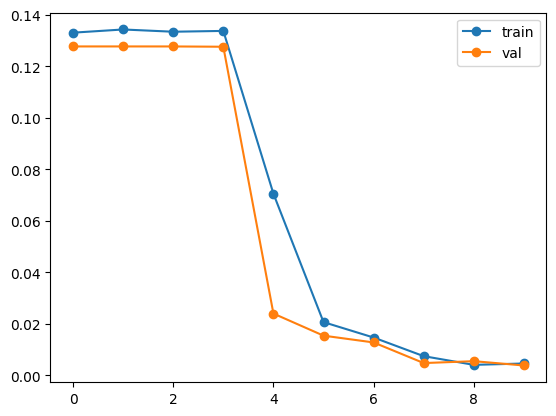

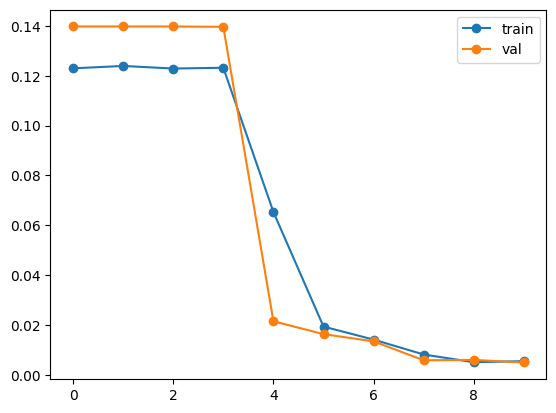

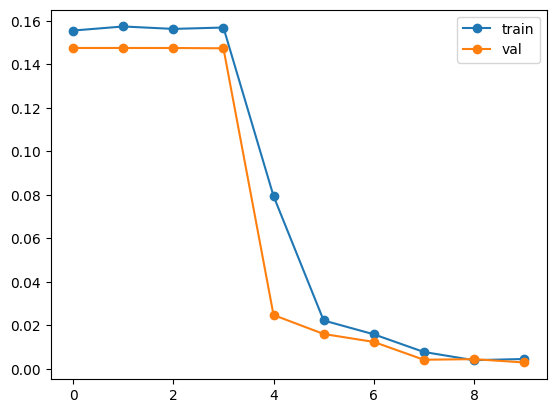


[Epoch    11 of 200] loss_1: 0.003127 val_loss_1: 0.003541 loss_2: 0.004003 val_loss_2: 0.004367 loss_3: 0.002990 val_loss_3: 0.002559
[model_1] Validation loss decreased (0.003871 --> 0.003541).  Saving model ...
[model_2] Validation loss decreased (0.004976 --> 0.004367).  Saving model ...
[model_3] Validation loss decreased (0.002936 --> 0.002559).  Saving model ...

[Epoch    12 of 200] loss_1: 0.003032 val_loss_1: 0.003419 loss_2: 0.003850 val_loss_2: 0.004118 loss_3: 0.002883 val_loss_3: 0.002465
[model_1] Validation loss decreased (0.003541 --> 0.003419).  Saving model ...
[model_2] Validation loss decreased (0.004367 --> 0.004118).  Saving model ...
[model_3] Validation loss decreased (0.002559 --> 0.002465).  Saving model ...

[Epoch    13 of 200] loss_1: 0.002700 val_loss_1: 0.003151 loss_2: 0.003445 val_loss_2: 0.003808 loss_3: 0.002551 val_loss_3: 0.002256
[model_1] Validation loss decreased (0.003419 --> 0.003151).  Saving model ...
[model_2] Validation loss decreased (0.

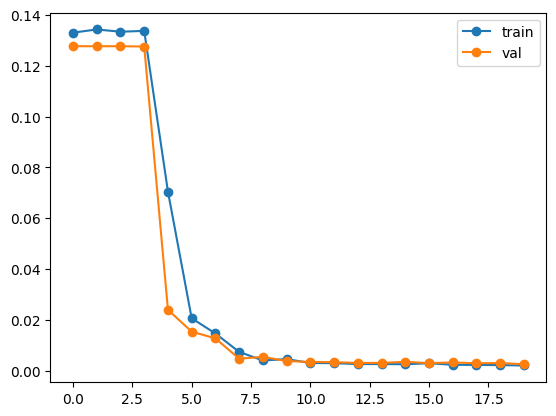

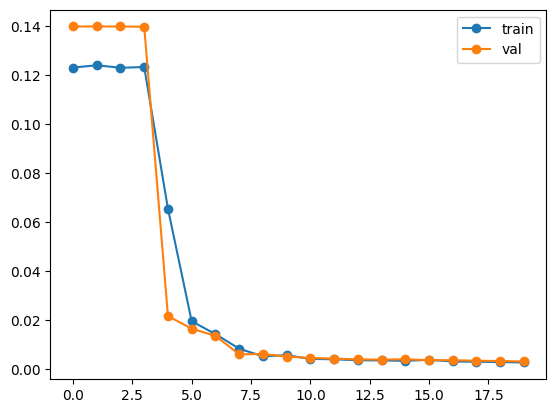

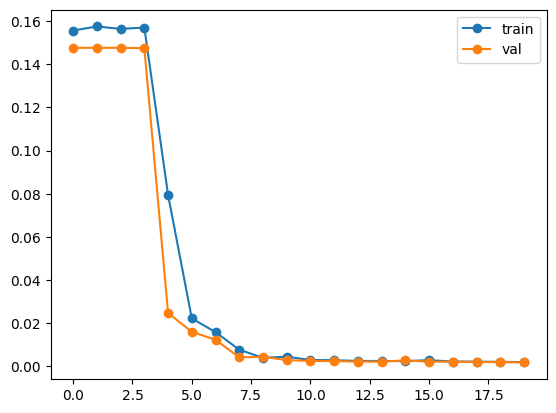


[Epoch    21 of 200] loss_1: 0.002166 val_loss_1: 0.002494 loss_2: 0.002493 val_loss_2: 0.002819 loss_3: 0.002047 val_loss_3: 0.001785
[model_1] Validation loss decreased (0.002629 --> 0.002494).  Saving model ...
[model_2] Validation loss decreased (0.002962 --> 0.002819).  Saving model ...
[model_3] Validation loss decreased (0.001846 --> 0.001785).  Saving model ...

[Epoch    22 of 200] loss_1: 0.002079 val_loss_1: 0.003301 loss_2: 0.002360 val_loss_2: 0.003166 loss_3: 0.001979 val_loss_3: 0.002472
[model_1] EarlyStopping counter: 1 out of 5
[model_2] EarlyStopping counter: 1 out of 5
[model_3] EarlyStopping counter: 1 out of 5

[Epoch    23 of 200] loss_1: 0.002286 val_loss_1: 0.002411 loss_2: 0.002552 val_loss_2: 0.002607 loss_3: 0.002162 val_loss_3: 0.001774
[model_1] Validation loss decreased (0.002494 --> 0.002411).  Saving model ...
[model_2] Validation loss decreased (0.002819 --> 0.002607).  Saving model ...
[model_3] Validation loss decreased (0.001785 --> 0.001774).  Sav

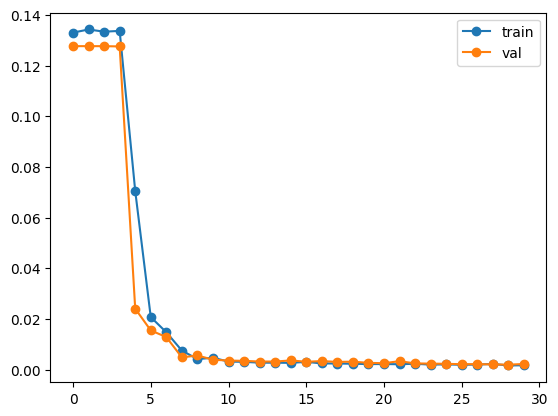

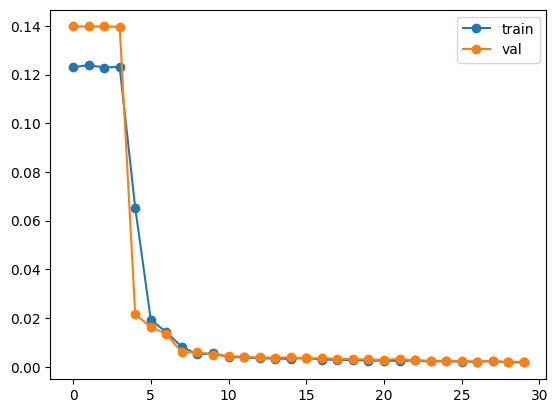

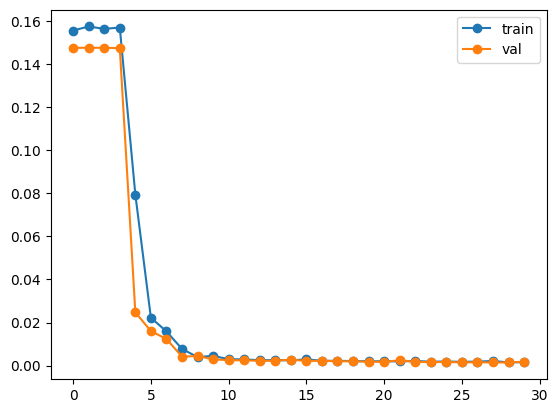


[Epoch    31 of 200] loss_1: 0.001623 val_loss_1: 0.001815 loss_2: 0.001710 val_loss_2: 0.001858 loss_3: 0.001564 val_loss_3: 0.001605
[model_1] Validation loss decreased (0.001914 --> 0.001815).  Saving model ...
[model_2] Validation loss decreased (0.001974 --> 0.001858).  Saving model ...
[model_3] EarlyStopping counter: 3 out of 5

[Epoch    32 of 200] loss_1: 0.001582 val_loss_1: 0.001743 loss_2: 0.001645 val_loss_2: 0.002069 loss_3: 0.001549 val_loss_3: 0.001469
[model_1] Validation loss decreased (0.001815 --> 0.001743).  Saving model ...
[model_2] EarlyStopping counter: 1 out of 5
[model_3] Validation loss decreased (0.001474 --> 0.001469).  Saving model ...

[Epoch    33 of 200] loss_1: 0.002118 val_loss_1: 0.002129 loss_2: 0.002218 val_loss_2: 0.001923 loss_3: 0.002113 val_loss_3: 0.001514
[model_1] EarlyStopping counter: 1 out of 5
[model_2] EarlyStopping counter: 2 out of 5
[model_3] EarlyStopping counter: 1 out of 5

[Epoch    34 of 200] loss_1: 0.001594 val_loss_1: 0.002

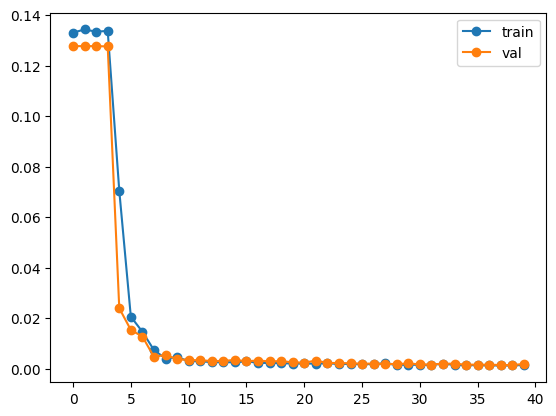

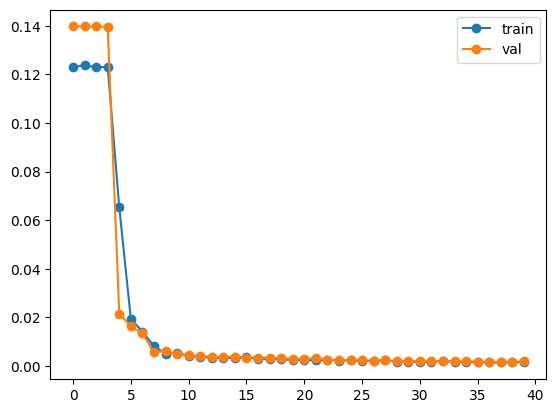

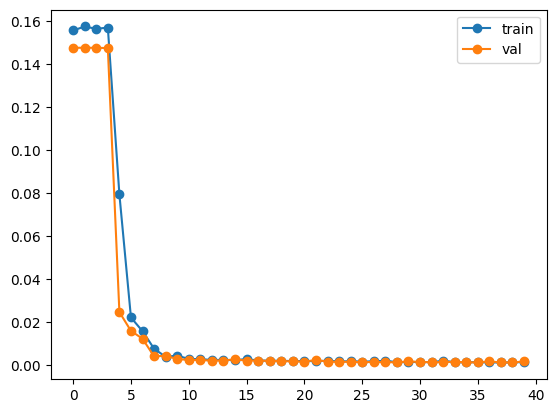


[Epoch    41 of 200] loss_1: 0.001328 val_loss_1: 0.001510 loss_2: 0.001391 val_loss_2: 0.001746 loss_3: 0.001325 val_loss_3: 0.001326
[model_1] Validation loss decreased (0.001540 --> 0.001510).  Saving model ...
[model_2] EarlyStopping counter: 3 out of 5
[model_3] Validation loss decreased (0.001355 --> 0.001326).  Saving model ...

[Epoch    42 of 200] loss_1: 0.001305 val_loss_1: 0.001529 loss_2: 0.001368 val_loss_2: 0.001766 loss_3: 0.001312 val_loss_3: 0.001351
[model_1] EarlyStopping counter: 1 out of 5
[model_2] EarlyStopping counter: 4 out of 5
[model_3] EarlyStopping counter: 1 out of 5

[Epoch    43 of 200] loss_1: 0.001451 val_loss_1: 0.001532 loss_2: 0.001512 val_loss_2: 0.001600 loss_3: 0.001463 val_loss_3: 0.001482
[model_1] EarlyStopping counter: 2 out of 5
[model_2] Validation loss decreased (0.001682 --> 0.001600).  Saving model ...
[model_3] EarlyStopping counter: 2 out of 5

[Epoch    44 of 200] loss_1: 0.001222 val_loss_1: 0.001499 loss_2: 0.001283 val_loss_2: 0.

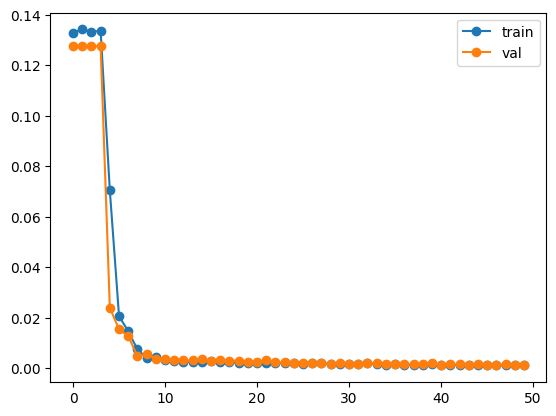

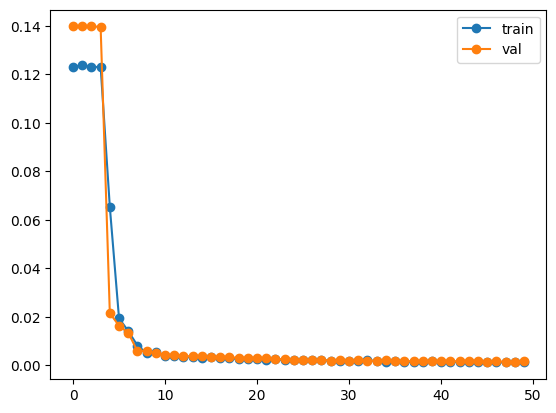

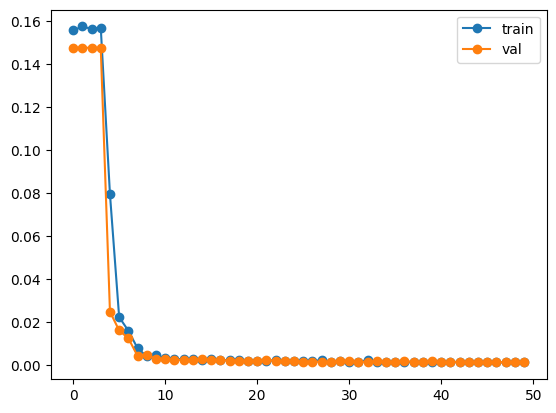


[Epoch    51 of 200] loss_1: 0.001170 val_loss_1: 0.001477 loss_2: 0.001215 val_loss_2: 0.001496 loss_3: 0.001183 val_loss_3: 0.001280
[model_1] EarlyStopping counter: 1 out of 5
[model_2] Validation loss decreased (0.001540 --> 0.001496).  Saving model ...
[model_3] EarlyStopping counter: 6 out of 5
Early stopping - model_3

[Epoch    52 of 200] loss_1: 0.001094 val_loss_1: 0.001456 loss_2: 0.001145 val_loss_2: 0.001481 loss_3: 0.001113 val_loss_3: 0.001343
[model_1] EarlyStopping counter: 2 out of 5
[model_2] Validation loss decreased (0.001496 --> 0.001481).  Saving model ...
[model_3] EarlyStopping counter: 7 out of 5
Early stopping - model_3

[Epoch    53 of 200] loss_1: 0.001129 val_loss_1: 0.001447 loss_2: 0.001169 val_loss_2: 0.001681 loss_3: 0.001135 val_loss_3: 0.001226
[model_1] EarlyStopping counter: 3 out of 5
[model_2] EarlyStopping counter: 1 out of 5
[model_3] EarlyStopping counter: 8 out of 5
Early stopping - model_3

[Epoch    54 of 200] loss_1: 0.001160 val_loss_1: 

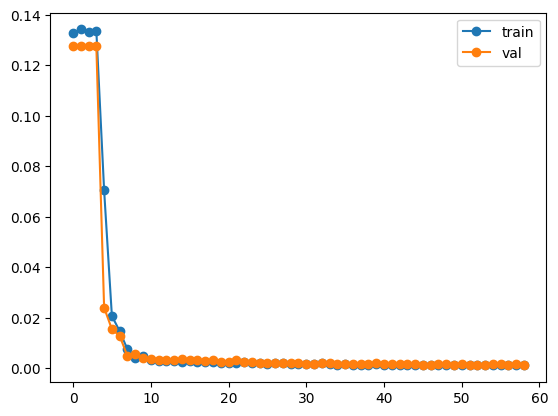

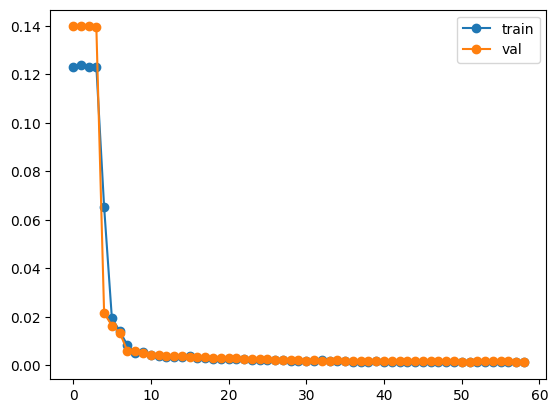

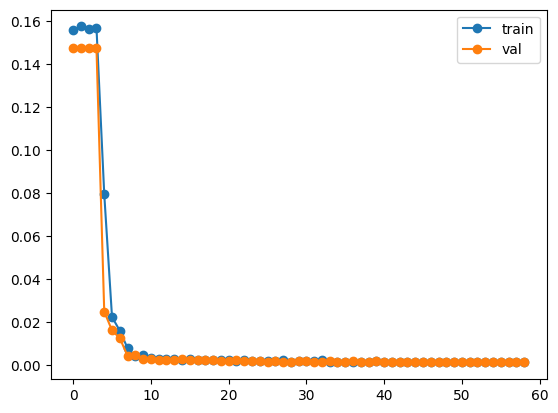


Total time of training: 0.5937801661756303 hours


In [54]:
start_time = time.time()

hist_loss_1 = np.zeros(config_args.epochs)
hist_loss_2 = np.zeros(config_args.epochs)
hist_loss_3 = np.zeros(config_args.epochs)

val_hist_loss_1 = np.zeros(config_args.epochs)
val_hist_loss_2 = np.zeros(config_args.epochs)
val_hist_loss_3 = np.zeros(config_args.epochs)

val_loss_best_1 = np.inf
val_loss_best_2 = np.inf
val_loss_best_3 = np.inf

count_1 = 0
count_2 = 0
count_3 = 0

for epoch in range(config_args.epochs):

    # Switching all models in training mode
    model_1.train()
    model_2.train()
    model_3.train()

    running_loss_1 = 0
    running_loss_2 = 0
    running_loss_3 = 0


    for batch, (categorical_var, continuous_var, target_var) in enumerate(train_dataloader):

        # Setting the gradients to zero
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        optimizer_3.zero_grad()

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 6:12]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 12:18]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)

        # Calculating the pinball loss
        loss_1 = loss_function(out_transformer_1, zone_1_target.to(device))
        loss_2 = loss_function(out_transformer_2, zone_2_target.to(device))
        loss_3 = loss_function(out_transformer_3, zone_3_target.to(device))

        # Back-Propagating the loss
        loss_1.backward()
        loss_2.backward()
        loss_3.backward()

        # Updating the parameters
        optimizer_1.step()
        optimizer_2.step()
        optimizer_3.step()

        # Accumulating the running loss
        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()
        running_loss_3 += loss_3.item()

        train_loss_1 = running_loss_1/len(train_dataloader)
        train_loss_2 = running_loss_2/len(train_dataloader)
        train_loss_3 = running_loss_3/len(train_dataloader)

        val_loss_1 = compute_val_point_score(model_1, test_dataloader,
                                             loss_function, "zone_1",
                                             device).item()
        val_loss_2 = compute_val_point_score(model_2, test_dataloader,
                                             loss_function, "zone_2",
                                             device).item()
        val_loss_3 = compute_val_point_score(model_3, test_dataloader,
                                             loss_function, "zone_3",
                                             device).item()

        hist_loss_1[epoch] = train_loss_1
        hist_loss_2[epoch] = train_loss_2
        hist_loss_3[epoch] = train_loss_3

        val_hist_loss_1[epoch] = val_loss_1
        val_hist_loss_2[epoch] = val_loss_2
        val_hist_loss_3[epoch] = val_loss_3
    
#     # Checking the change in learning rates
#     before_lr_1 = optimizer_1.param_groups[0]["lr"]
#     before_lr_2 = optimizer_2.param_groups[0]["lr"]
#     before_lr_3 = optimizer_3.param_groups[0]["lr"]
    
#     scheduler_1.step()
#     scheduler_2.step()
#     scheduler_3.step()
    
#     after_lr_1 = optimizer_1.param_groups[0]["lr"]
#     after_lr_2 = optimizer_2.param_groups[0]["lr"]
#     after_lr_3 = optimizer_3.param_groups[0]["lr"]

#     print('LR_1: {before_1:1.6f} -> {after_1:1.6f}, LR_2: {before_2:1.6f} -> {after_2:1.6f}, LR_3: {before_3:1.6f} -> {after_3:1.6f}'.format(t=epoch+1,
#                                                                                epochs=config_args.epochs,
#                                                                                before_1=before_lr_1, after_1=after_lr_1,
#                                                                                before_2=before_lr_2, after_2=after_lr_2,
#                                                                                before_3=before_lr_3, after_3=after_lr_3,
#                                                                                ))

    
    print('\n[Epoch {t:5d} of {epochs}] loss_1: {loss_1:1.6f} val_loss_1: {val_loss_1:1.6f} loss_2: {loss_2:1.6f} val_loss_2: {val_loss_2:1.6f} loss_3: {loss_3:1.6f} val_loss_3: {val_loss_3:1.6f}'.format(t=epoch+1,
                                                                                                                                                                                                          epochs=config_args.epochs,
                                                                                                                                                                                                          loss_1=train_loss_1,
                                                                                                                                                                                                          val_loss_1=val_loss_1,
                                                                                                                                                                                                          loss_2=train_loss_2, 
                                                                                                                                                                                                          val_loss_2=val_loss_2,
                                                                                                                                                                                                          loss_3=train_loss_3,
                                                                                                                                                                                                          val_loss_3=val_loss_3))
    
    # Employing early stopping to avoid overfitting
    early_stopping_1(val_loss_1, model_1)
    early_stopping_2(val_loss_2, model_2)
    early_stopping_3(val_loss_3, model_3)

    if early_stopping_1.early_stop and count_1 < 1:
        print("Early stopping - {}".format(early_stopping_1.model_name))

    if early_stopping_2.early_stop and count_2 < 1:
        print("Early stopping - {}".format(early_stopping_2.model_name))

    if early_stopping_3.early_stop and count_3 < 1:
        print("Early stopping - {}".format(early_stopping_3.model_name))

    if all((early_stopping_1.early_stop, early_stopping_2.early_stop, early_stopping_3.early_stop)):
        print("\nAll model stopped early...")
        break

    if (epoch + 1) % config_args.update_freq == 0:
        print("The plots at epoch {} are:\n".format(epoch+1))
        plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_2, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_3, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        
plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_2, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_3, 'b'), 'o-', label='val')
plt.legend()
plt.show()
        
end_time = time.time()

total_time = end_time - start_time
print("\nTotal time of training: {} hours".format(total_time/3600))

### LOADING AND GENERATING RESULTS ON TEST DATALOADER

In [55]:
# Loading the models
best_vae_transformer_1 = load_from_checkpoint(model_1, model_path_1)
best_vae_transformer_2 = load_from_checkpoint(model_2, model_path_2)
best_vae_transformer_3 = load_from_checkpoint(model_3, model_path_3)

In [56]:
point_pred_1 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_2 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_3 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
idx_pred_1 = 0
idx_pred_2 = 0
idx_pred_3 = 0

# Switching all models to eval mode
model_1.eval()
model_2.eval()
model_3.eval()

with torch.no_grad():
    for (categorical_var, continuous_var, target_var) in tqdm(test_dataloader, total=len(test_dataloader)):

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 6:12]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 12:18]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)

        # Concatenating the predictions
        point_pred_1[idx_pred_1:idx_pred_1+zone_1_continuous.shape[0]] = out_transformer_1.cpu().numpy()

        point_pred_2[idx_pred_2:idx_pred_2+zone_2_continuous.shape[0]] = out_transformer_2.cpu().numpy()

        point_pred_3[idx_pred_3:idx_pred_3+zone_3_continuous.shape[0]] = out_transformer_3.cpu().numpy()

        idx_pred_1 += zone_1_continuous.shape[0]
        idx_pred_2 += zone_2_continuous.shape[0]
        idx_pred_3 += zone_3_continuous.shape[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


#### FORMATTING PREDICTED AND TRUE DATA FOR GENERATING RESULTS

In [57]:
# Reshaping the predicted quantiles
point_pred_arr_1 = point_pred_1.reshape(-1, model_args.d_output)
point_pred_arr_2 = point_pred_2.reshape(-1, model_args.d_output)
point_pred_arr_3 = point_pred_3.reshape(-1, model_args.d_output)

point_pred_arr_1.shape

(8760, 1)

In [58]:
point_pred_1_inv = point_pred_arr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
point_pred_2_inv = point_pred_arr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
point_pred_3_inv = point_pred_arr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]

point_pred_1_inv.shape

(8760, 1)

In [59]:
# Reshaping the true data
Y_test_1 = target_samples_testing[:, :, 0:1]
Y_test_2 = target_samples_testing[:, :, 1:2]
Y_test_3 = target_samples_testing[:, :, 2:3]

yArr_1 = Y_test_1.reshape(Y_test_1.shape[0] * Y_test_1.shape[1], Y_test_1.shape[2]).numpy()
yArr_2 = Y_test_2.reshape(Y_test_2.shape[0] * Y_test_2.shape[1], Y_test_2.shape[2]).numpy()
yArr_3 = Y_test_3.reshape(Y_test_3.shape[0] * Y_test_3.shape[1], Y_test_3.shape[2]).numpy()

yArr_1.shape

(8760, 1)

In [60]:
yArr_1_inv = yArr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
yArr_2_inv = yArr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
yArr_3_inv = yArr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]

#### CALCULATING THE MAPE ON TEST DATA

In [61]:
compare_df_1 = pd.DataFrame(data= {"Values": yArr_1_inv[:, 0], "Predictions": point_pred_1_inv[:, 0]})
compare_df_1

,Values,Predictions
0,25457.519531,25814.267256
1,24341.429688,25218.884422
2,23409.070312,24771.608537
3,22785.869141,24680.931930
4,22584.080078,25192.210923
...,...,...
8755,31844.076172,33551.582722
8756,30687.078125,33088.317924
8757,29583.296875,31517.611364
8758,28458.691406,29732.466112


In [62]:
compare_df_2 = pd.DataFrame(data= {"Values": yArr_2_inv[:, 0], "Predictions": point_pred_2_inv[:, 0]})
compare_df_2

,Values,Predictions
0,9088.189453,9359.190489
1,8684.293945,8986.407485
2,8323.870117,8810.800231
3,8164.973145,8687.548453
4,8126.982422,8919.345004
...,...,...
8755,11682.099609,11676.110516
8756,11442.870117,11345.093775
8757,11166.769531,10793.070224
8758,10838.549805,10075.564772


In [63]:
compare_df_3 = pd.DataFrame(data= {"Values": yArr_3_inv[:, 0], "Predictions": point_pred_3_inv[:, 0]})
compare_df_3

,Values,Predictions
0,37595.378906,39457.715840
1,36246.585938,38361.613610
2,35429.871094,37237.043864
3,35011.558594,37881.384131
4,35128.800781,38287.864236
...,...,...
8755,49258.609375,51434.654693
8756,47886.875000,50908.066995
8757,46582.285156,49222.985517
8758,45132.980469,46763.365740


In [64]:
print("Saving the best trained models.")

# Saving the models
torch.save(best_vae_transformer_1, f"vae_transformer_models/L1_vae_transformer_1.pth")
torch.save(best_vae_transformer_2, f"vae_transformer_models/L1_vae_transformer_2.pth")
torch.save(best_vae_transformer_3, f"vae_transformer_models/L1_vae_transformer_3.pth")

print("Saved !")

Saving the best trained models.
Saved !


#### EXAMINING THE RESULTS

In [65]:
mape_max_val = mm_scaler_Y.data_max_.max()

New MAPE:  1.2816967970194286
Old MAPE:  1.7695985210831746


<Axes: >

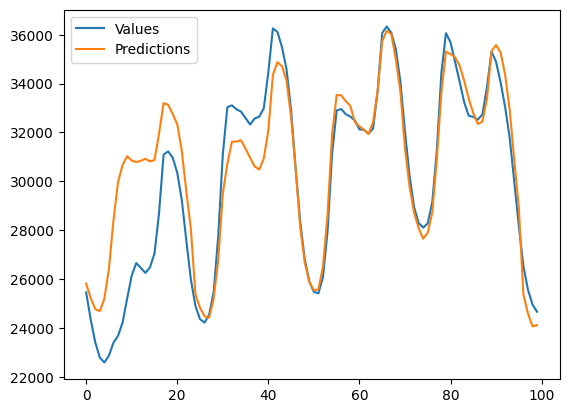

In [66]:
result_mape_1 = new_mape(compare_df_1["Values"], compare_df_1["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_1)
print("Old MAPE: ", mape(compare_df_1["Values"], compare_df_1["Predictions"]))
compare_df_1.iloc[:100].plot()

New MAPE:  0.557127210344668
Old MAPE:  2.1838767509238175


<Axes: >

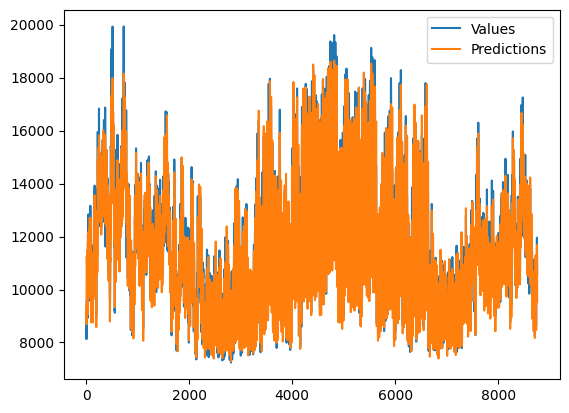

In [67]:
result_mape_2 =  new_mape(compare_df_2["Values"], compare_df_2["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_2)
print("Old MAPE: ", mape(compare_df_2["Values"], compare_df_2["Predictions"]))
compare_df_2.plot()

New MAPE:  1.5114133094424065
Old MAPE:  1.541228388111644


<Axes: >

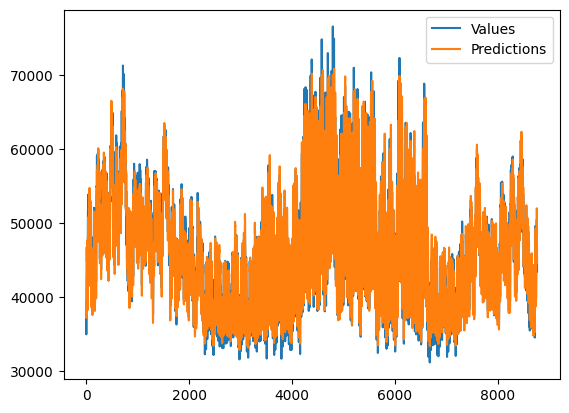

In [68]:
result_mape_3 = new_mape(compare_df_3["Values"], compare_df_3["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_3)
print("Old MAPE: ", mape(compare_df_3["Values"], compare_df_3["Predictions"]))
compare_df_3.plot()

In [69]:
resultsDf = pd.DataFrame()
resultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
resultsDf["mape"] = [
result_mape_1, result_mape_2, result_mape_3,
]

resultsDf.to_csv(os.path.join("lag_24_results", "new_v2_" + dataset + ".csv"), index=False)
print("Results saved !")

resultsDf

Results saved !


,zone,mape
0,MIDATL,1.281697
1,SOUTH,0.557127
2,WEST,1.511413


In [70]:
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [71]:
oldResultsDf = pd.DataFrame()
oldResultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
oldResultsDf["mape"] = [
    mape(compare_df_1["Values"], compare_df_1["Predictions"]), 
    mape(compare_df_2["Values"], compare_df_2["Predictions"]), 
    mape(compare_df_3["Values"], compare_df_3["Predictions"]),
]

oldResultsDf.to_csv(os.path.join("lag_24_results", "old_v2_" + dataset + ".csv"), index=False)
print("Results saved !")

oldResultsDf

Results saved !


,zone,mape
0,MIDATL,1.769599
1,SOUTH,2.183877
2,WEST,1.541228
